<a href="https://colab.research.google.com/github/fadibechara/Predictive_Maintenance/blob/main/Predictive_maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive Maintenance - Machine Learning - TurboFan Engines

In [1]:
import pandas as pd
import plotly.express as px
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import RandomizedSearchCV
import time

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  

from itertools import cycle

from sklearn import metrics

from sklearn import model_selection
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.multiclass import OneVsRestClassifier

from sklearn.preprocessing import StandardScaler, LabelBinarizer
import seaborn as sn

In [2]:
raw_data = pd.read_csv('train_FD001.txt', sep=' ', header = None)
raw_data.tail(15)

0    1       2       3      4   ...     23     24       25  26  27
20616  100  186  0.0026  0.0004  100.0  ...  100.0  38.51  23.1173 NaN NaN
20617  100  187  0.0015  0.0002  100.0  ...  100.0  38.67  23.2308 NaN NaN
20618  100  188 -0.0008 -0.0002  100.0  ...  100.0  38.36  23.0552 NaN NaN
20619  100  189  0.0015  0.0001  100.0  ...  100.0  38.65  23.0591 NaN NaN
20620  100  190 -0.0001  0.0002  100.0  ...  100.0  38.42  23.0603 NaN NaN
20621  100  191 -0.0005 -0.0000  100.0  ...  100.0  38.39  23.1218 NaN NaN
20622  100  192 -0.0009  0.0001  100.0  ...  100.0  38.56  23.0770 NaN NaN
20623  100  193 -0.0001  0.0002  100.0  ...  100.0  38.47  23.0230 NaN NaN
20624  100  194 -0.0011  0.0003  100.0  ...  100.0  38.38  23.1324 NaN NaN
20625  100  195 -0.0002 -0.0001  100.0  ...  100.0  38.14  23.1923 NaN NaN
20626  100  196 -0.0004 -0.0003  100.0  ...  100.0  38.49  22.9735 NaN NaN
20627  100  197 -0.0016 -0.0005  100.0  ...  100.0  38.30  23.1594 NaN NaN
20628  100  198  0.0004  0.0000  100.0  ...  100.0  38.44  22.9333 NaN NaN
20629  100  199 -0.0011  0.0003  100.0  ...  100.0  38.29  23.0640 NaN NaN
20630  100  200 -0.0032 -0.0005  100.0  ...  100.0  38.37  23.0522 NaN NaN

[15 rows x 28 columns]

In [3]:
raw_data.drop(26, axis=1, inplace=True)

In [4]:
raw_data.drop(27, axis=1, inplace=True)

In [5]:
raw_data = raw_data[[f for f in range(0,26)]]
raw_data.columns = ['ID', 'Cycle', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1', 'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8', 'SensorMeasure9', 'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12', 'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15', 'SensorMeasure16', 'SensorMeasure17', 'SensorMeasure18', 'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21']
raw_data

ID  Cycle  OpSet1  ...  SensorMeasure19  SensorMeasure20  SensorMeasure21
0        1      1 -0.0007  ...            100.0            39.06          23.4190
1        1      2  0.0019  ...            100.0            39.00          23.4236
2        1      3 -0.0043  ...            100.0            38.95          23.3442
3        1      4  0.0007  ...            100.0            38.88          23.3739
4        1      5 -0.0019  ...            100.0            38.90          23.4044
...    ...    ...     ...  ...              ...              ...              ...
20626  100    196 -0.0004  ...            100.0            38.49          22.9735
20627  100    197 -0.0016  ...            100.0            38.30          23.1594
20628  100    198  0.0004  ...            100.0            38.44          22.9333
20629  100    199 -0.0011  ...            100.0            38.29          23.0640
20630  100    200 -0.0032  ...            100.0            38.37          23.0522

[20631 rows x 26 columns]

In [6]:
max_cycles_df = raw_data.groupby(['ID'], sort=False)['Cycle'].max().reset_index().rename(columns={'Cycle':'MaxCycleID'})
max_cycles_df.tail(10)

ID  MaxCycleID
90   91         135
91   92         341
92   93         155
93   94         258
94   95         283
95   96         336
96   97         202
97   98         156
98   99         185
99  100         200

In [7]:
# merge back to original dataset
FD001_df = pd.merge(raw_data, max_cycles_df, how='inner', on='ID')
FD001_df['RUL'] = FD001_df['MaxCycleID'] - FD001_df['Cycle']
FD001_df

ID  Cycle  OpSet1  ...  SensorMeasure21  MaxCycleID  RUL
0        1      1 -0.0007  ...          23.4190         192  191
1        1      2  0.0019  ...          23.4236         192  190
2        1      3 -0.0043  ...          23.3442         192  189
3        1      4  0.0007  ...          23.3739         192  188
4        1      5 -0.0019  ...          23.4044         192  187
...    ...    ...     ...  ...              ...         ...  ...
20626  100    196 -0.0004  ...          22.9735         200    4
20627  100    197 -0.0016  ...          23.1594         200    3
20628  100    198  0.0004  ...          22.9333         200    2
20629  100    199 -0.0011  ...          23.0640         200    1
20630  100    200 -0.0032  ...          23.0522         200    0

[20631 rows x 28 columns]

In [8]:
FD001_df.to_csv('NASA_Full.csv', index=None)

With this chart we can see that the Max-RUL values of the engines present in the dataset vary between 130 to 360 cycles of operation.

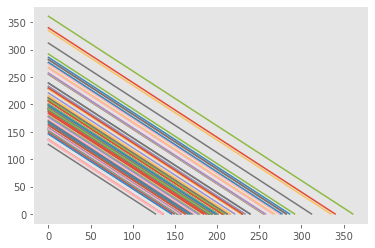

In [9]:
one_engine = []
for i,r in FD001_df.iterrows():
    rul = r['RUL']
    one_engine.append(rul)
    if rul == 0:
        plt.plot(one_engine)
        one_engine = []
        
plt.grid()

# Exploratory Data Analayis and Visualization

What we will be interested in accomplishing with this part of the study is understanding what is happening in our dataset and extracting any potential insights that may help us in making better decisions for establishing our predictive models.

Eliminating certain columns i.e features after our EDA is possible if any features are considered as stagnant throughout the LifeTime of all of the engines. This will help in dismissing the features that will not play a substantial role in crafting our model since they would presumably not impact our engine's remaining useful life throughout its operation.

Additionally, insights and corelations may be ultimately extracted due to the nature of the dataset. Sensor measure values that uniquely increse or decrease over time might give us hints as to which features play a considerable role in determining our engine's remaining useful and state of operation.

In [ ]:
fig = px.line(raw_data, x = 'Cycle', y = 'OpSet1', color='ID', title = 'Variation of Operation Setting 1 over Cycle LifeTime until failure' )
fig.show()

In [ ]:
fig = px.line(raw_data, x = 'Cycle', y = 'OpSet2', color='ID', title = 'Variation of Operation Setting 2 over Cycle LifeTime until failure' )
fig.show()

In [ ]:
fig = px.line(raw_data, x = 'Cycle', y = 'OpSet3', color='ID', title = 'Variation of Operation Setting 3 over Cycle LifeTime until failure' )
fig.show()

In [ ]:
fig = px.line(raw_data, x = 'Cycle', y = 'SensorMeasure1', color='ID', title = 'Variation of Sensor Measure 1 over Cycle LifeTime until failure' )
fig.show()

In [ ]:
fig = px.line(raw_data, x = 'Cycle', y = 'SensorMeasure2', color='ID', title = 'Variation of Sensor Measure 2 over Cycle LifeTime until failure' )
fig.show()

In [ ]:
fig = px.line(raw_data, x = 'Cycle', y = 'SensorMeasure3', color='ID', title = 'Variation of Sensor Measure 3 over Cycle LifeTime until failure' )
fig.show()

In [ ]:
fig = px.line(raw_data, x = 'Cycle', y = 'SensorMeasure4', color='ID', title = 'Variation of Sensor Measure 4 over Cycle LifeTime until failure' )
fig.show()

In [ ]:
fig = px.line(raw_data, x = 'Cycle', y = 'SensorMeasure5', color='ID', title = 'Variation of Sensor Measure 5 over Cycle LifeTime until failure' )
fig.show()

In [ ]:
fig = px.line(raw_data, x = 'Cycle', y = 'SensorMeasure6', color='ID', title = 'Variation of Sensor Measure 6 over Cycle LifeTime until failure' )
fig.show()

In [ ]:
fig = px.line(raw_data, x = 'Cycle', y = 'SensorMeasure7', color='ID', title = 'Variation of Sensor Measure 7 over Cycle LifeTime until failure' )
fig.show()

In [ ]:
fig = px.line(raw_data, x = 'Cycle', y = 'SensorMeasure8', color='ID', title = 'Variation of Sensor Measure 8 over Cycle LifeTime until failure' )
fig.show()

In [ ]:
fig = px.line(raw_data, x = 'Cycle', y = 'SensorMeasure9', color='ID', title = 'Variation of Sensor Measure 9 over Cycle LifeTime until failure' )
fig.show()

In [ ]:
fig = px.line(raw_data, x = 'Cycle', y = 'SensorMeasure10', color='ID', title = 'Variation of Sensor Measure 10 over Cycle LifeTime until failure' )
fig.show()

In [ ]:
fig = px.line(raw_data, x = 'Cycle', y = 'SensorMeasure11', color='ID', title = 'Variation of Sensor Measure 11 over Cycle LifeTime until failure' )
fig.show()

In [ ]:
fig = px.line(raw_data, x = 'Cycle', y = 'SensorMeasure12', color='ID', title = 'Variation of Sensor Measure 12 over Cycle LifeTime until failure' )
fig.show()

In [ ]:
fig = px.line(raw_data, x = 'Cycle', y = 'SensorMeasure13', color='ID', title = 'Variation of Sensor Measure 13 over Cycle LifeTime until failure' )
fig.show()

In [ ]:
fig = px.line(raw_data, x = 'Cycle', y = 'SensorMeasure14', color='ID', title = 'Variation of Sensor Measure 14 over Cycle LifeTime until failure' )
fig.show()

In [ ]:
fig = px.line(raw_data, x = 'Cycle', y = 'SensorMeasure15', color='ID', title = 'Variation of Sensor Measure 15 over Cycle LifeTime until failure' )
fig.show()

In [ ]:
fig = px.line(raw_data, x = 'Cycle', y = 'SensorMeasure16', color='ID', title = 'Variation of Sensor Measure 16 over Cycle LifeTime until failure' )
fig.show()

In [ ]:
fig = px.line(raw_data, x = 'Cycle', y = 'SensorMeasure17', color='ID', title = 'Variation of Sensor Measure 17 over Cycle LifeTime until failure' )
fig.show()

In [ ]:
fig = px.line(raw_data, x = 'Cycle', y = 'SensorMeasure18', color='ID', title = 'Variation of Sensor Measure 18 over Cycle LifeTime until failure' )
fig.show()

In [ ]:
fig = px.line(raw_data, x = 'Cycle', y = 'SensorMeasure19', color='ID', title = 'Variation of Sensor Measure 19 over Cycle LifeTime until failure' )
fig.show()

In [ ]:
fig = px.line(raw_data, x = 'Cycle', y = 'SensorMeasure20', color='ID', title = 'Variation of Sensor Measure 20 over Cycle LifeTime until failure' )
fig.show()

In [ ]:
fig = px.line(raw_data, x = 'Cycle', y = 'SensorMeasure21', color='ID', title = 'Variation of Sensor Measure 21 over Cycle LifeTime until failure' )
fig.show()

# Eliminitaing ineffective features

Now that can we can clearly see which sensors do not affect the Remaining useful life factor at all, we can cancel them out and not take them into consideration.

These unbenificial factors are : OpSet3, SensorMeasure1, SensorMeasure5, SensorMeasure6, SensorMeasure10, SensorMeasure16, SensorMeasure18, SensorMeasure19.

We will proceed to deleting these columns from our dataframe, and later on going a step further with our dimensionality reduction to view the factors that explain our datasets variance by 90%.

In [19]:
FD001_df = FD001_df.drop(['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10', 'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19'], axis = 1)

In [12]:
FD001_df['State_of_Operation'] = ['Imminent' if out < 30 else 'Intermediately Dangerous' if 29 < out <70 else 'Slightly Dangerous' if 69 < out < 111 else 'SAFE' for out in FD001_df['RUL']]

In [13]:
FD001_df

ID  Cycle  OpSet1  ...  MaxCycleID  RUL  State_of_Operation
0        1      1 -0.0007  ...         192  191                SAFE
1        1      2  0.0019  ...         192  190                SAFE
2        1      3 -0.0043  ...         192  189                SAFE
3        1      4  0.0007  ...         192  188                SAFE
4        1      5 -0.0019  ...         192  187                SAFE
...    ...    ...     ...  ...         ...  ...                 ...
20626  100    196 -0.0004  ...         200    4            Imminent
20627  100    197 -0.0016  ...         200    3            Imminent
20628  100    198  0.0004  ...         200    2            Imminent
20629  100    199 -0.0011  ...         200    1            Imminent
20630  100    200 -0.0032  ...         200    0            Imminent

[20631 rows x 29 columns]

In [14]:
dependant_variables = FD001_df[['ID', 'Cycle', 'MaxCycleID', 'RUL', 'State_of_Operation']].copy()

In [15]:
dependant_variables

ID  Cycle  MaxCycleID  RUL State_of_Operation
0        1      1         192  191               SAFE
1        1      2         192  190               SAFE
2        1      3         192  189               SAFE
3        1      4         192  188               SAFE
4        1      5         192  187               SAFE
...    ...    ...         ...  ...                ...
20626  100    196         200    4           Imminent
20627  100    197         200    3           Imminent
20628  100    198         200    2           Imminent
20629  100    199         200    1           Imminent
20630  100    200         200    0           Imminent

[20631 rows x 5 columns]

Now let's remove the dependant variables from our dataframe to begin the Dimensionality reduction process.

In [20]:
FD001_df = FD001_df.drop(['ID', 'MaxCycleID', 'RUL', 'State_of_Operation', 'Cycle'], axis = 1)

In [21]:
FD001_df 

OpSet1  OpSet2  ...  SensorMeasure20  SensorMeasure21
0     -0.0007 -0.0004  ...            39.06          23.4190
1      0.0019 -0.0003  ...            39.00          23.4236
2     -0.0043  0.0003  ...            38.95          23.3442
3      0.0007  0.0000  ...            38.88          23.3739
4     -0.0019 -0.0002  ...            38.90          23.4044
...       ...     ...  ...              ...              ...
20626 -0.0004 -0.0003  ...            38.49          22.9735
20627 -0.0016 -0.0005  ...            38.30          23.1594
20628  0.0004  0.0000  ...            38.44          22.9333
20629 -0.0011  0.0003  ...            38.29          23.0640
20630 -0.0032 -0.0005  ...            38.37          23.0522

[20631 rows x 16 columns]

# Correlation Matrix

Now we will plot the correlation matrix of our remaining values to investigate the relationship between the different variables.


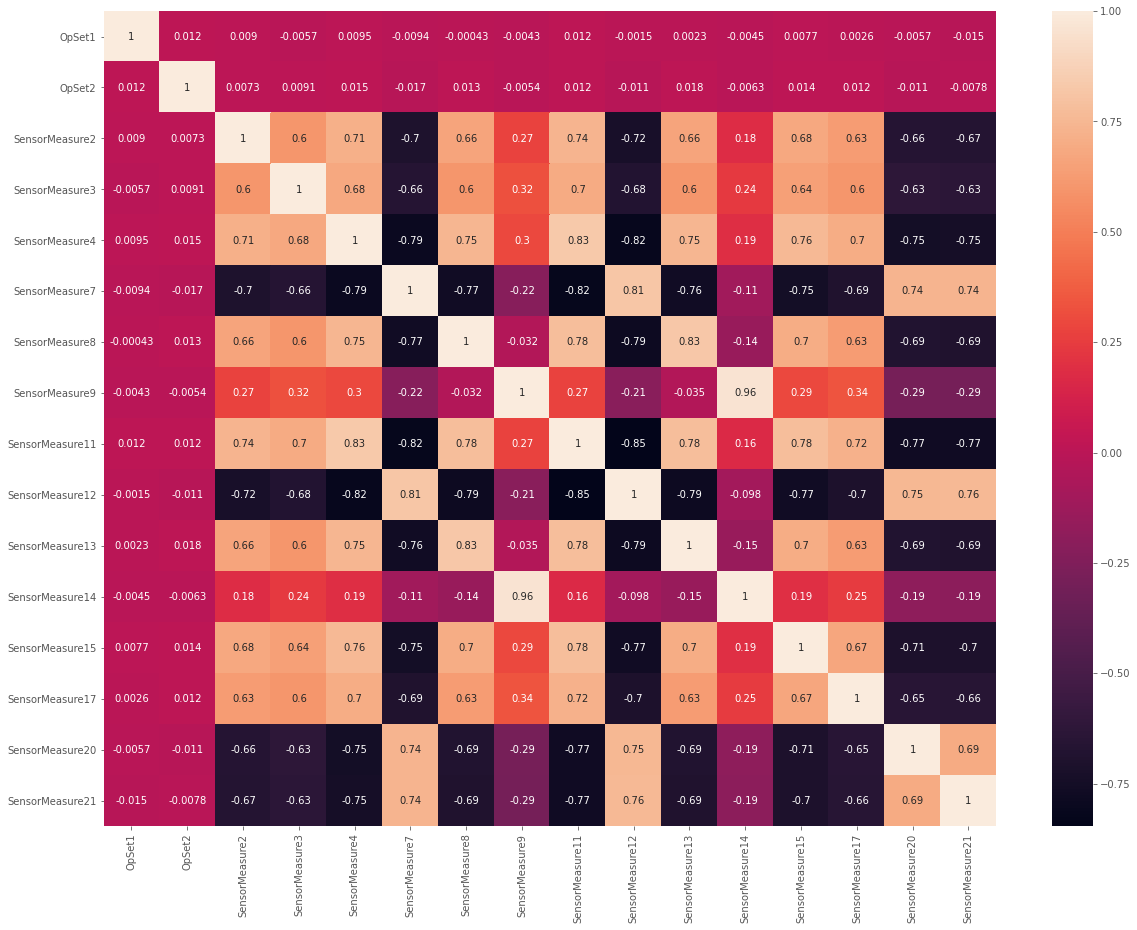

In [22]:
corrMatrix = FD001_df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.gcf().set_size_inches(20, 15)
plt.show()

In [23]:
del FD001_df['SensorMeasure9']

# Dimensionality Reduction

Now that we have preprocessed the data and figured out which are the most probable factors that might influence our predictive model, we will implement the PCA dimensionality reduction to further reduce the number of our principal components which explain our dataset and its variability the most. 

This will help our ML models in making better predictions whether regarding regression or classification

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [25]:
from sklearn.decomposition import PCA

In [26]:
pca = PCA(0.90)

In [27]:
scaler.fit(FD001_df)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [28]:
independant_variables = scaler.transform(FD001_df)

In [29]:
independant = pca.fit_transform(independant_variables)

In [30]:
pca.explained_variance_ratio_

array([0.59374859, 0.08271624, 0.06742321, 0.0659025 , 0.02749715,
       0.02448175, 0.02310242, 0.02039463])

In [31]:
independant

array([[-2.89090515, -0.07722144, -1.17990763, ...,  0.67727196,
        -0.28966456,  0.01586611],
       [-2.28256987, -0.40247661, -0.09078164, ...,  0.32527923,
         0.0156476 , -0.33227079],
       [-2.94425933, -0.56365139, -0.72247432, ..., -1.06174782,
        -0.50586212,  0.25928279],
       ...,
       [ 8.05224851, -0.12921426,  0.09858148, ...,  1.14283613,
        -0.3269825 ,  0.79460892],
       [ 7.76262206, -0.58806949,  0.27952893, ..., -0.10228576,
        -1.39689482, -0.40053128],
       [ 7.92520786, -0.75048524, -2.30826989, ..., -0.34535081,
        -0.09337136, -0.06396764]])

In [32]:
principal_independant = pd.DataFrame(data = independant)

In [33]:
 principal_independant

0         1         2  ...         5         6         7
0     -2.890905 -0.077221 -1.179908  ...  0.677272 -0.289665  0.015866
1     -2.282570 -0.402477 -0.090782  ...  0.325279  0.015648 -0.332271
2     -2.944259 -0.563651 -0.722474  ... -1.061748 -0.505862  0.259283
3     -3.332342 -0.856081  0.209112  ... -0.039641  0.153103 -0.116298
4     -2.402875 -0.294498 -1.090374  ...  0.330609  0.066270 -0.490300
...         ...       ...       ...  ...       ...       ...       ...
20626  6.915735 -0.466304 -0.885193  ...  0.587068 -0.040318  0.925677
20627  7.062222 -0.512233 -1.774186  ... -0.387620 -0.603791 -1.092302
20628  8.052249 -0.129214  0.098581  ...  1.142836 -0.326982  0.794609
20629  7.762622 -0.588069  0.279529  ... -0.102286 -1.396895 -0.400531
20630  7.925208 -0.750485 -2.308270  ... -0.345351 -0.093371 -0.063968

[20631 rows x 8 columns]

In [34]:
principal_independant['RUL'] = dependant_variables['RUL'].values

In [35]:
dependant_variables

ID  Cycle  MaxCycleID  RUL State_of_Operation
0        1      1         192  191               SAFE
1        1      2         192  190               SAFE
2        1      3         192  189               SAFE
3        1      4         192  188               SAFE
4        1      5         192  187               SAFE
...    ...    ...         ...  ...                ...
20626  100    196         200    4           Imminent
20627  100    197         200    3           Imminent
20628  100    198         200    2           Imminent
20629  100    199         200    1           Imminent
20630  100    200         200    0           Imminent

[20631 rows x 5 columns]

In [36]:
unique, counts = np.unique(dependant_variables['State_of_Operation'], return_counts=True)
dict(zip(unique, counts))

{'Imminent': 3000,
 'Intermediately Dangerous': 4000,
 'SAFE': 9531,
 'Slightly Dangerous': 4100}

In [37]:
principal_independant

0         1         2  ...         6         7  RUL
0     -2.890905 -0.077221 -1.179908  ... -0.289665  0.015866  191
1     -2.282570 -0.402477 -0.090782  ...  0.015648 -0.332271  190
2     -2.944259 -0.563651 -0.722474  ... -0.505862  0.259283  189
3     -3.332342 -0.856081  0.209112  ...  0.153103 -0.116298  188
4     -2.402875 -0.294498 -1.090374  ...  0.066270 -0.490300  187
...         ...       ...       ...  ...       ...       ...  ...
20626  6.915735 -0.466304 -0.885193  ... -0.040318  0.925677    4
20627  7.062222 -0.512233 -1.774186  ... -0.603791 -1.092302    3
20628  8.052249 -0.129214  0.098581  ... -0.326982  0.794609    2
20629  7.762622 -0.588069  0.279529  ... -1.396895 -0.400531    1
20630  7.925208 -0.750485 -2.308270  ... -0.093371 -0.063968    0

[20631 rows x 9 columns]

# Regression point of view

In this portion of the study, the RUL of each cycle in the test set will be predicted after training our machine learning model.

We will evaluate the model's performance by looking at the Root Mean Squared Error and judging how reliable that error would be throughout the actual deployment.

In [38]:
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(principal_independant, test_size=0.2)

In [39]:
y_train=x_train['RUL']
x_train=x_train.drop(['RUL'],axis=1)

In [40]:
y_test=x_test['RUL']
x_test=x_test.drop(['RUL'],axis=1)

In [41]:
y_test

19784    103
10756     30
16404    187
18954     56
19286    265
        ... 
9864      44
8806     244
7247      68
13007    111
2105      30
Name: RUL, Length: 4127, dtype: int64

In [42]:
y_train

4932     177
9334     161
4615     117
13184    247
15295     73
        ... 
11337     54
19711    176
10213    121
3335     245
18025    200
Name: RUL, Length: 16504, dtype: int64

Attempting regular linear regression to get a hint of the RMSE value with a very basic ML model.

In [50]:
lm = LinearRegression()
scores = cross_val_score(lm, x_train, y_train, cv=10, scoring='neg_mean_squared_error')
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)
print(rmse_scores)
print(rmse_scores.mean())

[44.44460237 44.48748187 44.7636114  43.32668761 45.40982783 45.38662398
 46.16765381 43.69123512 46.18258255 44.696151  ]
44.85564575365869


In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# Basic Model Comparison

We are interested in the following 14 regression models.

All initialized with default parameters except random_state and n_jobs.

We will then proceed with the 2 models which obtained the least RMSE score out of the 14 models.

In [49]:
seed = 43

'''Initialize all the regression models object we are interested in.'''
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor



linear = LinearRegression(n_jobs = -1)
lasso = Lasso(random_state = seed)
ridge = Ridge(random_state = seed)
kr = KernelRidge()
elnt = ElasticNet(random_state = seed)
dt = DecisionTreeRegressor(random_state = seed)
svm = SVR()
knn = KNeighborsRegressor(n_jobs = -1)
rf =  RandomForestRegressor(n_jobs = -1, random_state = seed)
et = ExtraTreesRegressor(n_jobs = -1, random_state = seed)
ab = AdaBoostRegressor(random_state = seed)
gb = GradientBoostingRegressor(random_state = seed)
xgb = XGBRegressor(random_state = seed, n_jobs = -1)
lgb = LGBMRegressor(random_state = seed, n_jobs = -1)

In [91]:

def cross_validate(model):
    from sklearn.model_selection import cross_val_score
    neg_x_val_score = cross_val_score(model, x_train, y_train, cv = 10, n_jobs = -1, scoring = 'neg_mean_squared_error')
    x_val_score = np.round(np.sqrt(-1*neg_x_val_score), 5)
    return x_val_score.mean()

models = [lasso, ridge, kr, elnt, dt, svm, knn, rf, et, ab, gb, xgb, lgb]
cross_val_scores = []
for model in models:
    cross_val_scores.append(cross_validate(model))


x_val_score = pd.DataFrame(data = cross_val_scores, columns = ['Cross Validation Scores (RMSE)'])
x_val_score.index = ['LSO', 'RIDGE', 'KR', 'ELNT', 'DT', 'SVM', 'KNN', 'RF', 'ET', 'AB', 'GB', 'XGB', 'LGB']
x_val_score = x_val_score.round(5)
x = x_val_score.index
y = x_val_score['Cross Validation Scores (RMSE)']
title = "Models' 10-fold Cross Validation Scores (RMSE)"
##s = scatter_plot(x, y, title, 'Models','RMSE', 30, 'Viridis')

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



In [148]:
y

LSO       44.60869
RIDGE     44.59304
KR       116.48456
ELNT      44.75968
DT        58.98368
SVM       42.58078
KNN       45.22441
RF        41.90233
ET        42.12170
AB        44.36506
GB        41.17028
XGB       41.12285
LGB       41.38098
Name: Cross Validation Scores (RMSE), dtype: float64

# XGBoost Fitting

In [51]:
xgb = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 nthread=4,
 seed=27)

In [52]:
regressor = xgb

In [53]:
regressor.fit(x_train,y_train)

[07:00:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
             silent=None, subsample=1, verbosity=1)

In [187]:
accuracyxgboost = round(regressor.score(x_train, y_train)*100,2)
predict_xgboost = regressor.predict(x_test) 
msexgboost = mean_squared_error(y_test,predict_xgboost)
rmsexgboost= np.sqrt(msexgboost)

In [188]:
rmsexgboost

41.8154367881205

# HyperParameter Tuning for Model Optimisation - XGBoost

In [200]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
 'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10), 'max_features':range(7,20,2), 'max_features':range(7,20,2)
}

In [201]:
random_cv = RandomizedSearchCV(estimator=xgb,
            param_distributions=param_test1,
            cv=10, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

In [202]:
random_cv.fit(x_train,y_train)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  5.2min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:  8.9min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 13.7min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed: 15.7min finished


[16:31:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=-1, nthread=None,
                                          objective='reg:linear',
                                          random_state=43, reg_alp...
                                          verbosity=1),
                   iid='deprecated', n_iter=50, n_jobs=4,
                   param_distributions={'max_depth': range(3, 10, 2),
    

In [203]:
random_cv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, max_features=11, min_child_weight=3,
             min_samples_leaf=60, min_samples_split=1600, missing=None,
             n_estimators=100, n_jobs=-1, nthread=None, objective='reg:linear',
             random_state=43, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [204]:
regressor = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, max_features=11, min_child_weight=3,
             min_samples_leaf=60, min_samples_split=1600, missing=None,
             n_estimators=100, n_jobs=-1, nthread=None, objective='reg:linear',
             random_state=43, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [205]:
regressor.fit(x_train,y_train)

[16:39:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, max_features=11, min_child_weight=3,
             min_samples_leaf=60, min_samples_split=1600, missing=None,
             n_estimators=100, n_jobs=-1, nthread=None, objective='reg:linear',
             random_state=43, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [77]:
accuracyxgboost = round(regressor.score(x_train, y_train)*100,2)
predict_xgboost = regressor.predict(x_test)

In [80]:
msexgboost = mean_squared_error(y_test,predict_xgboost)
rmsexgboost= np.sqrt(msexgboost)
print(rmsexgboost)

43.99403592203796


Now let's make sure our regressor isn't predicting any negative RULs, and if it is actually doing so we will change the values of all negative predictions to zero since that is the minimum value our RUL can take.

In [82]:
for i in predict_xgboost:
  if i<0 : print(i)

-1.6242893
-5.553154
-2.5952435
-2.093513
-0.63559747
-3.7691193
-2.7923603
-0.43196845
-1.4717447
-1.3843539
-16.402416
-0.8717313
-2.6439323
-0.44821763
-4.4766974
-0.5458088
-3.5698786
-0.38168257
-1.0151901
-8.278066
-0.05607772
-3.8185859
-4.532603
-3.2298744
-2.6808622
-0.26533794
-1.6673934
-27.82587
-10.421637
-2.947204
-21.378334
-2.5507853
-11.570476
-3.8231373
-4.8163886
-0.4326179
-0.31153405
-0.17336422
-4.815362
-5.6920857
-1.0971863


In [83]:
predict_xgboost[predict_xgboost < 0] = 0

In [84]:
for i in predict_xgboost:
  if i<0 : print(i)

In [89]:
predict_xgboost

array([102.41593 ,  23.421413, 158.53967 , ...,  93.83802 , 134.6396  ,
        41.531193], dtype=float32)

In [90]:
y_test

19784    103
10756     30
16404    187
18954     56
19286    265
        ... 
9864      44
8806     244
7247      68
13007    111
2105      30
Name: RUL, Length: 4127, dtype: int64

In [87]:
msexgboost = mean_squared_error(y_test,predict_xgboost)
rmsexgboost= np.sqrt(msexgboost)

# RMSE Score on Test Set

Though this score is somewhat acceptable, it is definitely not optimal.

Perhaps more advanced models can be used in deployment involving LSTMs or Deep Nerual Networks to obtain a lower RMSE score hence higher functional Reliability.

In [88]:
rmsexgboost

43.98434709050729

# Classification point of view

Now we will be tackling our dataset from a classifiction perspective.

4 categories have been determined: Imminent, intermediately dangerous, slightly dangerous and safe.

Each one of these classes represents a state of operation for the engines in the dataset depending on how many cycles the engine is away from **complete failure.**

In [92]:
classification_set = principal_independant

In [93]:
classification_set['State_of_Operation'] = dependant_variables['State_of_Operation'].values

In [94]:
classification_set = classification_set.drop(['RUL'],axis=1)

In [95]:
classification_set

0         1         2  ...         6         7  State_of_Operation
0     -2.890905 -0.077221 -1.179908  ... -0.289665  0.015866                SAFE
1     -2.282570 -0.402477 -0.090782  ...  0.015648 -0.332271                SAFE
2     -2.944259 -0.563651 -0.722474  ... -0.505862  0.259283                SAFE
3     -3.332342 -0.856081  0.209112  ...  0.153103 -0.116298                SAFE
4     -2.402875 -0.294498 -1.090374  ...  0.066270 -0.490300                SAFE
...         ...       ...       ...  ...       ...       ...                 ...
20626  6.915735 -0.466304 -0.885193  ... -0.040318  0.925677            Imminent
20627  7.062222 -0.512233 -1.774186  ... -0.603791 -1.092302            Imminent
20628  8.052249 -0.129214  0.098581  ... -0.326982  0.794609            Imminent
20629  7.762622 -0.588069  0.279529  ... -1.396895 -0.400531            Imminent
20630  7.925208 -0.750485 -2.308270  ... -0.093371 -0.063968            Imminent

[20631 rows x 9 columns]

In [100]:
from sklearn.model_selection import train_test_split

class_x_train, class_x_test = train_test_split(classification_set, test_size=0.2)

In [101]:
class_y_train=class_x_train['State_of_Operation']
class_x_train=class_x_train.drop(['State_of_Operation'],axis=1)

In [102]:
unique, counts = np.unique(class_y_train, return_counts=True)
dict(zip(unique, counts))

{'Imminent': 2400,
 'Intermediately Dangerous': 2370,
 'SAFE': 9236,
 'Slightly Dangerous': 2498}

In [103]:
class_y_test=class_x_test['State_of_Operation']
class_x_test=class_x_test.drop(['State_of_Operation'],axis=1)

In [104]:
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

# Testing Various Classifiers for Accuracy Score

9 different classifiers will be tested and compared with regards to their Accuracy Score in classification on the training set with 10-Fold Cross Validation.

The top 2 Classifiers will then be examined on the Test Set.

In [105]:
seed = 27

linear_svc = LinearSVC()
logreg = LogisticRegression(random_state = seed)
dtc = DecisionTreeClassifier(random_state = seed)
gnbc = GaussianNB()
knnc = KNeighborsClassifier(n_jobs = -1)
rfc =  RandomForestClassifier(n_jobs = -1, random_state = seed)
sgdc = SGDClassifier(n_jobs = -1, random_state = seed)
gbc = GradientBoostingClassifier(random_state = seed)
xgbc = XGBClassifier(random_state = seed,n_estimators=100, n_jobs = -1)

In [113]:
def class_cross_validate(model):
    from sklearn.model_selection import cross_val_score
    accuracy_score = cross_val_score(model, class_x_train, class_y_train, cv = 10, n_jobs = -1, scoring = 'accuracy')
    ##x_val_score = np.round(np.sqrt(-1*neg_x_val_score), 5)
    return accuracy_score.mean()

models = [linear_svc, logreg, dtc, gnbc, knnc, rfc, sgdc, gbc, xgbc]
class_cross_val_scores = []
for model in models:
    class_cross_val_scores.append(class_cross_validate(model))


x_val_score = pd.DataFrame(data = class_cross_val_scores, columns = ['Cross Validation Scores (Accuracy)'])
x_val_score.index = ['LinearSVC', 'LogisticRegression', 'DecisionTreeClassifier', 'GaussianNB', 'KNeighborsClassifier', 'RandomForestClassifier', 'SGDClassifier', 'GradientBoostingClassifier', 'XGBClassifier']
x_val_score = x_val_score.round(5)
x = x_val_score.index
y = x_val_score['Cross Validation Scores (Accuracy)']
title = "Models' 10-fold Cross Validation Scores (CLASSIFICATION ACCURACY)"
##s = scatter_plot(x, y, title, 'Models','RMSE', 30, 'Viridis')

In [70]:
clf = RandomForestClassifier(max_depth = 20, 
                             n_estimators = 30, 
                             n_jobs = -1)
clf.fit(class_x_train, class_y_train)
clf.score(class_x_test, class_y_test)

0.7555124787981584

In [114]:
y

LinearSVC                     0.73140
LogisticRegression            0.76290
DecisionTreeClassifier        0.68856
GaussianNB                    0.75582
KNeighborsClassifier          0.74406
RandomForestClassifier        0.77248
SGDClassifier                 0.73207
GradientBoostingClassifier    0.77963
XGBClassifier                 0.77933
Name: Cross Validation Scores (Accuracy), dtype: float64

In [138]:
gbc.fit(class_x_train, class_y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=27, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [139]:
y_pred = gbc.predict(class_x_test)

In [140]:
acc_gbc = (y_pred == class_y_test).sum().astype(float) / len(y_pred)*100
print(acc_gbc)

77.95008480736612


In [141]:
xgbc.fit(class_x_train, class_y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [142]:
y_pred = xgbc.predict(class_x_test)

In [143]:
acc_xgbc = (y_pred == class_y_test).sum().astype(float) / len(y_pred)*100
print(acc_xgbc)

77.80470075115096


In [131]:

training_start = time.perf_counter()
xgbc.fit(class_x_train, class_y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgbc.predict(class_x_test)
prediction_end = time.perf_counter()
acc_xgbc = (preds == class_y_test).sum().astype(float) / len(preds)*100
xgbc_train_time = training_end-training_start
xgbc_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgbc))
print("Time consumed for training: %4.3f" % (xgbc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgbc_prediction_time))

XGBoost's prediction accuracy is: 77.80
Time consumed for training: 4.341
Time consumed for prediction: 0.04647 seconds


# Confusion Matrix

This type of matrix is used to visualize where the model made mistakes in its classification predictions.

In [133]:
print(cm(class_y_test, preds, labels=['Imminent', 'Intermediately Dangerous', 'SAFE', 'Slightly Dangerous']))

[[ 491  106    3    0]
 [  57  390  127   56]
 [   0   30 2221   44]
 [   0  105  388  109]]


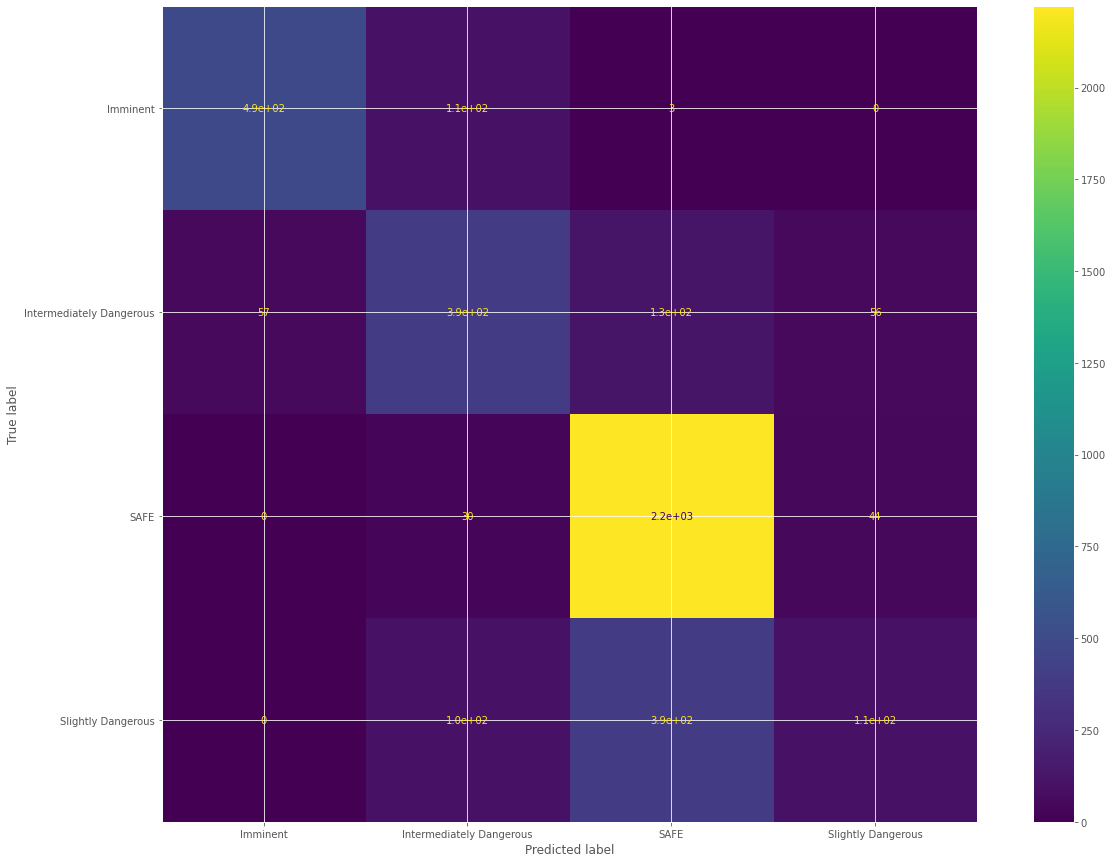

In [110]:
plot_confusion_matrix(xgbc, class_x_test, class_y_test)  
plt.gcf().set_size_inches(20, 15)
plt.show()

In [134]:
training_start = time.perf_counter()
knnc.fit(class_x_train, class_y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds_k = knnc.predict(class_x_test)
prediction_end = time.perf_counter()
acc_knn = (preds_k == class_y_test).sum().astype(float) / len(preds)*100
knn_train_time = training_end-training_start
knn_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: %3.2f" % (acc_knn))
print("Time consumed for training: %4.3f seconds" % (knn_train_time))
print("Time consumed for prediction: %6.5f seconds" % (knn_prediction_time))

Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: 74.36
Time consumed for training: 0.041 seconds
Time consumed for prediction: 0.31297 seconds


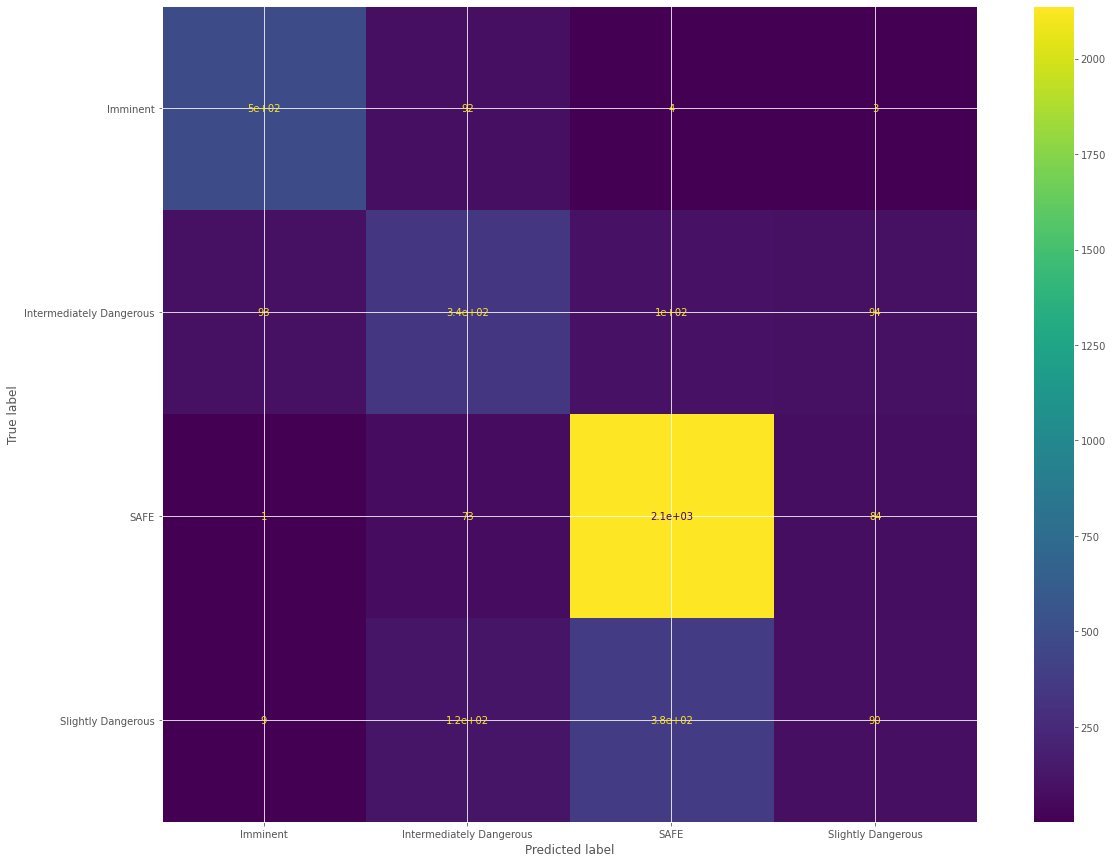

In [135]:
plot_confusion_matrix(knnc, class_x_test, class_y_test)  
plt.gcf().set_size_inches(20, 15)
plt.show()

In [107]:
class_y_test

In [132]:
preds

array(['SAFE', 'SAFE', 'SAFE', ..., 'Imminent',
       'Intermediately Dangerous', 'Intermediately Dangerous'],
      dtype=object)

In [111]:
print(classification_report(class_y_test, preds))

                          precision    recall  f1-score   support

                Imminent       0.90      0.82      0.86       600
Intermediately Dangerous       0.62      0.62      0.62       630
                    SAFE       0.81      0.97      0.88      2295
      Slightly Dangerous       0.52      0.18      0.27       602

                accuracy                           0.78      4127
               macro avg       0.71      0.65      0.66      4127
            weighted avg       0.75      0.78      0.75      4127



We can see that even though the results with **XgBoostClassifier** are acceptable, 'slightly dangerous' instances are often being **misclassified** on the test set as 'SAFE' or 'intermediately dangerous'. This might cause problems problems in operation and forecasting measures moving on.

Thus either hyperparameter tuning should be performed on the XGBoost algorithm or another approach should be considered.

In [112]:
preds

array(['SAFE', 'SAFE', 'SAFE', ..., 'Imminent',
       'Intermediately Dangerous', 'Intermediately Dangerous'],
      dtype=object)

In [250]:
clf_dtra = DecisionTreeClassifier(random_state=123)
gs_params = {'max_depth': [ 4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}

In [251]:
grid_search = model_selection.GridSearchCV(estimator=clf_dtra, param_grid=gs_params, cv=10, scoring='accuracy', n_jobs=-1)

grid_search.fit(class_x_train, class_y_train)
y_pred = grid_search.predict(class_x_test)

In [258]:
grid_search.best_score_

0.7677539048877632

In [254]:
clf_dtra = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')



In [256]:
clf_dtra.fit(class_x_train, class_y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

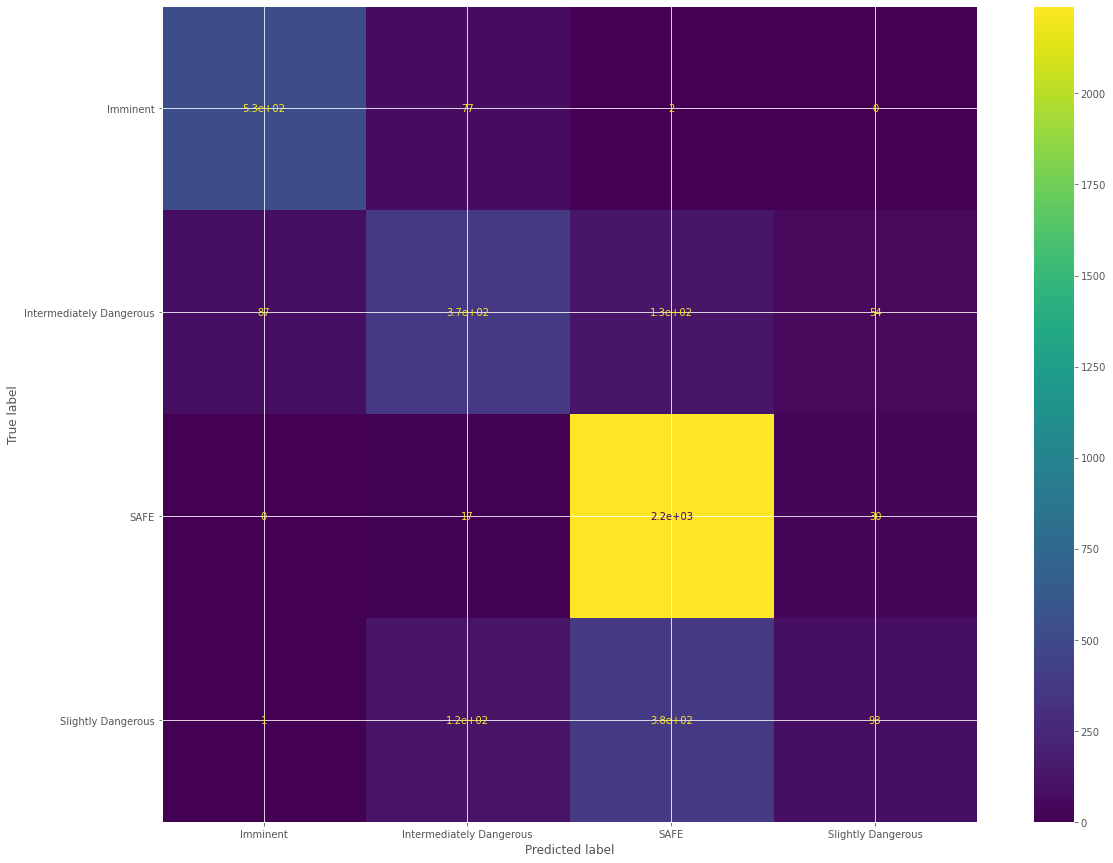

In [257]:
plot_confusion_matrix(clf_dtra, class_x_test, class_y_test)  
plt.gcf().set_size_inches(20, 15)
plt.show()

In [117]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# RandomSearch Hypermater Tuning - XGBoostClassifier

In [123]:
xgbct = XGBClassifier(random_state=123)
gs_params = {'booster': ['gbtree','gblinear'],'subsample': [0.5,0.6,0.7,0.8,0.9,1.0],'lambda':['0.5','0.75','1.0'] ,'max_depth': [3,4,5,6,7,8,9,10,12], 'criterion': ['gini', 'entropy']}

In [124]:
random_search = RandomizedSearchCV(xgbct, param_distributions=gs_params,
                                   n_iter=20, cv=10)
random_search.fit(class_x_train, class_y_train)

In [144]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, criterion='entropy',
              gamma=0, lambda='1.0', learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='multi:softprob',
              random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1.0, verbosity=1)

In [126]:
random_search.best_score_

0.7793263586806894

In [145]:
y_pred = random_search.predict(class_x_test)

In [146]:
acc_xgbc_tuned = (y_pred == class_y_test).sum().astype(float) / len(y_pred)*100

In [147]:
acc_xgbc_tuned

77.80470075115096

# Summary

Depending on the use cases in partciular industries either a regression model could be considered or a multiclass classification scenario.

A Predictive Maintenance system would help various industries in making better decisions concerning their maintenance routines and maintaining a more informed forecast of their supply chain and human resource needs with regards to operations and maitenance practices.

